In [1]:
# modules required for handling dataframes
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from math import acos, degrees, log2
from dictances import bhattacharyya_coefficient
from dictances import bhattacharyya
from scipy.spatial import distance

In [2]:
def get_reference_df(sample, sequencing_tech):
    if sample == 'IE1':
        barcode = '05'
    elif sample == 'MC1':
        barcode = '06'
    else:
        print('Wrong sample name. Please choose from [IE1] or [MC1].')   
    
    if sequencing_tech == 'illumina':
        reference_db = 'mock_com_all'
        sourcedir = '/home/yiheng/MinION_data/mock_com/illumina/'
        reference_tab_dir = os.path.join(sourcedir, sample, 'finaldf.%s.%s.blast.tab' % (sample, reference_db))
        reference_df = pd.read_csv(reference_tab_dir, sep='\t', index_col=0)
        reference_df_trim = reference_df[~reference_df.superkingdom.isna()]
        reference_df_trim = reference_df_trim.reset_index(drop=True)
        return reference_df_trim

    elif sequencing_tech == 'nanopore':
        reference_db = 'goldstandard'
        sourcedir = '/home/yiheng/MinION_data/'
        reference_tab_dir = os.path.join(sourcedir, 'barcode%s' % barcode, '%s_nanopore_%sdb_blast.tab' % (sample, reference_db))
        reference_df = pd.read_csv(reference_tab_dir, sep='\t', index_col=0)
        reference_df['pmatch'] = reference_df.pmatch*100
        return reference_df
    else:
        print('Wrong sequencing tech. Please choose from [illumina] or [nanopore].')    

In [3]:
def get_blast_df(sample, sequencing_tech, db='refseq_fungi_updated'):
    if sample == 'IE1':
        barcode = '05'
    elif sample == 'MC1':
        barcode = '06'
    else:
        print('Wrong sample name. Please choose from [IE1] or [MC1].')
     
    if sequencing_tech == 'illumina':
        reference_db = 'mock_com_all'
        sourcedir = '/home/yiheng/MinION_data/mock_com/illumina/'
        blast_fungi_tab_dir = os.path.join(sourcedir, sample, 'finaldf.%s.%s.blast.tab' % (sample, db))
        blast_fungi_df = pd.read_csv(blast_fungi_tab_dir, sep='\t', index_col=0)
        blast_fungi_df_trim = blast_fungi_df[~blast_fungi_df.pident.isna()]
        blast_fungi_df_trim = blast_fungi_df_trim.reset_index(drop=True)
        return blast_fungi_df_trim
    elif sequencing_tech == 'nanopore':
        reference_db = 'goldstandard'
        sourcedir = '/home/yiheng/MinION_data/'
        blast_fungi_tab_dir = os.path.join(sourcedir, 'barcode%s' % barcode, 'barcode%s.%sdb_blast.tab' % (barcode, db))
        blast_fungi_df = pd.read_csv(blast_fungi_tab_dir, sep='\t', index_col=0)
        return blast_fungi_df
    else:
        print('Wrong sequencing tech. Please choose from [illumina] or [nanopore].')

In [4]:
### Please note the small difference of the function for each script
def generate_taxonomy_pivot_sum_blast_fungi(sequencing_tech, tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    if sequencing_tech == 'illumina':
        pivot_table = tax_df.pivot_table(values='len', 
                                            index=rank, 
                                            columns='superkingdom', 
                                            aggfunc='sum', 
                                            fill_value=0)
    elif sequencing_tech == 'nanopore':
        pivot_table = tax_df.pivot_table(values='sequence_length_template_blast', 
                                            index=rank, 
                                            columns='superkingdom_blast', 
                                            aggfunc='sum', 
                                            fill_value=0)
    else:
        print('Wrong sequencing tech. Please choose from [illumina] or [nanopore].')
    pivot_table.columns.name = None
    pivot_table = pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)
    return pivot_table


In [5]:
def generate_ncbi_taxonomy_pivot(sequencing_tech, tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    if sequencing_tech == 'illumina':
        pivot_table = tax_df.pivot_table(values='total_cov', 
                                            index=rank, 
                                            columns='superkingdom', 
                                            aggfunc='sum', 
                                            fill_value=0)
    elif sequencing_tech == 'nanopore':
        pivot_table = tax_df.pivot_table(values='sequence_length_template', 
                                            index=rank, 
                                            columns='superkingdom', 
                                            aggfunc='sum', 
                                            fill_value=0)
    else:
        print('Wrong sequencing tech. Please choose from [illumina] or [nanopore].')
    pivot_table.columns.name = None
    pivot_table = pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)
    return pivot_table

In [6]:
# This is used for blast goldstandard db outputs
def trim_pivot_genus_reference(distance, tax_df_pivot):
# merge candida genera
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Candida'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] = \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Candida'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] + \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Diutina'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] + \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Nakaseomyces'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')]
# merge cryptococcus genera
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Cryptococcus'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] = \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Cryptococcus'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] + \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Filobasidium'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] + \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Naganishia'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')]
# merge Trichosporon genera
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Trichosporon'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] = \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Trichosporon'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] + \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Cutaneotrichosporon'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')]

# Now drop those genera that have been merged
    if distance == 'B':
        tax_df_pivot_drop = tax_df_pivot.drop(['Nakaseomyces', 'Diutina', 'Filobasidium', 'Naganishia', 'Cutaneotrichosporon'])
        # B_distance needs the relative abundance normalized to 100.
        tax_df_pivot_drop['relative_abundance'] = tax_df_pivot_drop.Eukaryota/tax_df_pivot_drop.Eukaryota.sum()*100
        tax_df_pivot_drop.loc['Others'] = [0,0]
        return tax_df_pivot_drop
    elif distance == 'L2':
        tax_df_pivot_drop = tax_df_pivot.drop(['Nakaseomyces', 'Diutina', 'Filobasidium', 'Naganishia', 'Cutaneotrichosporon'])
        # L2 distance needs the relative abundance normalized to 1.
        # This needs to be mannually changed each time
        tax_df_pivot_drop['relative_abundance'] = tax_df_pivot_drop.Eukaryota/tax_df_pivot_drop.Eukaryota.sum()
        tax_df_pivot_drop.loc['Others'] = [0,0]
        return tax_df_pivot_drop
    elif distance == 'KL':
        tax_df_pivot_drop = tax_df_pivot.drop(['Nakaseomyces', 'Diutina','Filobasidium', 'Naganishia', 'Cutaneotrichosporon'])
        # KL divergence needs the relative abundance normalized to 1.
        tax_df_pivot_drop['relative_abundance'] = tax_df_pivot_drop.Eukaryota/tax_df_pivot_drop.Eukaryota.sum()
        tax_df_pivot_drop_true = tax_df_pivot_drop[tax_df_pivot_drop.index.isin(genera_in_mock)]
        tax_df_pivot_drop_others = tax_df_pivot_drop[~tax_df_pivot_drop.index.isin(genera_in_mock)]
        tax_df_pivot_drop_true.loc['Others'] = [tax_df_pivot_drop_others.Eukaryota.sum(), 
                                                tax_df_pivot_drop_others.relative_abundance.sum()]
        # Here is an important adjustment for each relative abundance to enable calculation of KL divergence.
        tax_df_pivot_drop_true['relative_abundance_added'] = tax_df_pivot_drop_true['relative_abundance']+0.00000000001
        tax_df_pivot_drop_true['relative_abundance_adjust'] = tax_df_pivot_drop_true['relative_abundance_added']/(tax_df_pivot_drop_true['relative_abundance_added'].sum())
        return tax_df_pivot_drop_true   
    else:
        print('Chose wrong distance. Pick from [B] or [L2] or [KL]')

In [7]:
# This is used to trim the blast fungi db outputs
def trim_pivot_genus_blastdf(distance, tax_df_pivot):
# merge candida genera
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Candida'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] = \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Candida'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] + \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Diutina'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] + \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Nakaseomyces'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')]
# merge cryptococcus genera
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Cryptococcus'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] = \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Cryptococcus'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] + \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Naganishia'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')]
# merge Trichosporon genera
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Trichosporon'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] = \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Trichosporon'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')] + \
    tax_df_pivot.iloc[tax_df_pivot.index.get_loc('Cutaneotrichosporon'), 
                      tax_df_pivot.columns.get_loc('Eukaryota')]

# Now drop those genera that have been merged
    if distance == 'B':
        tax_df_pivot_drop = tax_df_pivot.drop(['Nakaseomyces', 'Diutina', 'Naganishia', 'Cutaneotrichosporon'])
        # B_distance needs the relative abundance normalized to 100.
        tax_df_pivot_drop['relative_abundance'] = tax_df_pivot_drop.Eukaryota/tax_df_pivot_drop.Eukaryota.sum()*100
        tax_df_pivot_drop_true = tax_df_pivot_drop[tax_df_pivot_drop.index.isin(genera_in_mock)]
        tax_df_pivot_drop_others = tax_df_pivot_drop[~tax_df_pivot_drop.index.isin(genera_in_mock)]
        tax_df_pivot_drop_true.loc['Others'] = [tax_df_pivot_drop_others.Eukaryota.sum(), 
                                                tax_df_pivot_drop_others.relative_abundance.sum()]
        return tax_df_pivot_drop_true
    elif distance == 'L2':
        tax_df_pivot_drop = tax_df_pivot.drop(['Nakaseomyces', 'Diutina', 'Naganishia', 'Cutaneotrichosporon'])
        # L2 distance needs the relative abundance normalized to 1.
        tax_df_pivot_drop['relative_abundance'] = tax_df_pivot_drop.Eukaryota/tax_df_pivot_drop.Eukaryota.sum()
        tax_df_pivot_drop_true = tax_df_pivot_drop[tax_df_pivot_drop.index.isin(genera_in_mock)]
        tax_df_pivot_drop_others = tax_df_pivot_drop[~tax_df_pivot_drop.index.isin(genera_in_mock)]
        tax_df_pivot_drop_true.loc['Others'] = [tax_df_pivot_drop_others.Eukaryota.sum(), 
                                                tax_df_pivot_drop_others.relative_abundance.sum()]
        return tax_df_pivot_drop_true  
    elif distance == 'KL':
        tax_df_pivot_drop = tax_df_pivot.drop(['Nakaseomyces', 'Diutina', 'Naganishia', 'Cutaneotrichosporon'])
        # KL divergence needs the relative abundance normalized to 1.
        tax_df_pivot_drop['relative_abundance'] = tax_df_pivot_drop.Eukaryota/tax_df_pivot_drop.Eukaryota.sum()
        tax_df_pivot_drop_true = tax_df_pivot_drop[tax_df_pivot_drop.index.isin(genera_in_mock)]
        tax_df_pivot_drop_others = tax_df_pivot_drop[~tax_df_pivot_drop.index.isin(genera_in_mock)]
        tax_df_pivot_drop_true.loc['Others'] = [tax_df_pivot_drop_others.Eukaryota.sum(), 
                                                tax_df_pivot_drop_others.relative_abundance.sum()]
        # Here is an important adjustment for each relative abundance to enable calculation of KL divergence.
        tax_df_pivot_drop_true['relative_abundance_added'] = tax_df_pivot_drop_true['relative_abundance']+0.00000000001
        tax_df_pivot_drop_true['relative_abundance_adjust'] = tax_df_pivot_drop_true['relative_abundance_added']/(tax_df_pivot_drop_true['relative_abundance_added'].sum())
        return tax_df_pivot_drop_true   
    else:
        print('Chose wrong distance. Pick from [B] or [L2] or [KL]')

In [8]:
def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))
def calculate_KL_pmatch(sequencing_tech, blast_df, reference_df, pmatch):
    # first calculate precision rate
#    reference_pivot = generate_ncbi_taxonomy_pivot(reference_df,  'genus', 'Eukaryota', 2000) 
    subset_reference_df = reference_df[reference_df.pmatch >= float(pmatch)]
    subset_reference_pivot = generate_ncbi_taxonomy_pivot(sequencing_tech, subset_reference_df,  'genus', 'Eukaryota', 2000)
    subset_reference_pivot_trim = trim_pivot_genus_reference('KL', subset_reference_pivot)
    
    if sequencing_tech == 'nanopore':
        subset_fungidb_blast_df = blast_df[blast_df.pmatch_blast >= float(pmatch)]
        fungidb_blast_pivot = generate_taxonomy_pivot_sum_blast_fungi(sequencing_tech, subset_fungidb_blast_df, 'genus_blast', 'Eukaryota', 2000)
        fungidb_blast_pivot_trim = trim_pivot_genus_blastdf('KL', fungidb_blast_pivot)
    else:
        subset_fungidb_blast_df = blast_df[blast_df.pmatch >= float(pmatch)]
        fungidb_blast_pivot = generate_taxonomy_pivot_sum_blast_fungi(sequencing_tech, subset_fungidb_blast_df, 'genus', 'Eukaryota', 2000)
        fungidb_blast_pivot_trim = trim_pivot_genus_blastdf('KL', fungidb_blast_pivot)

    reference_blast_merge = pd.merge(subset_reference_pivot_trim, fungidb_blast_pivot_trim, 
                                     how="outer", 
                                     left_on=subset_reference_pivot_trim.index, right_on=fungidb_blast_pivot_trim.index)    

    # now all dfs have been sorted, start calculating distance
    a = np.array((reference_blast_merge.relative_abundance_adjust_x))
    b = np.array((reference_blast_merge.relative_abundance_adjust_y))
    dist = kl_divergence(b, a)
    return dist

In [9]:
def calculate_Bdistance_pmatch(sequencing_tech, blast_df, reference_df, pmatch):
    # first calculate precision rate
#    reference_pivot = generate_ncbi_taxonomy_pivot(reference_df,  'genus', 'Eukaryota', 2000)
    subset_reference_df = reference_df[reference_df.pmatch >= float(pmatch)]
    subset_reference_pivot = generate_ncbi_taxonomy_pivot(sequencing_tech, subset_reference_df,  'genus', 'Eukaryota', 2000)
    subset_reference_pivot_trim = trim_pivot_genus_reference('B', subset_reference_pivot)
    
    if sequencing_tech == 'nanopore':
        subset_fungidb_blast_df = blast_df[blast_df.pmatch_blast >= float(pmatch)]
        fungidb_blast_pivot = generate_taxonomy_pivot_sum_blast_fungi(sequencing_tech, subset_fungidb_blast_df, 'genus_blast', 'Eukaryota', 2000)
        fungidb_blast_pivot_trim = trim_pivot_genus_blastdf('B', fungidb_blast_pivot)
    else:
        subset_fungidb_blast_df = blast_df[blast_df.pmatch >= float(pmatch)]
        fungidb_blast_pivot = generate_taxonomy_pivot_sum_blast_fungi(sequencing_tech, subset_fungidb_blast_df, 'genus', 'Eukaryota', 2000)
        fungidb_blast_pivot_trim = trim_pivot_genus_blastdf('B', fungidb_blast_pivot)
    
    # now all dfs have been sorted, start calculating distance
    subset_reference_pivot_dict = subset_reference_pivot_trim.to_dict()
    fungidb_blast_pivot_dict = fungidb_blast_pivot_trim.to_dict()
    
    blast_reference_distance = bhattacharyya_coefficient(fungidb_blast_pivot_dict['relative_abundance'], 
                                                         subset_reference_pivot_dict['relative_abundance'])
    angle_degree = degrees(acos(blast_reference_distance/100))
    return angle_degree

In [10]:
def calculate_L2_pmatch(sequencing_tech, blast_df, reference_df, pmatch):
    # first calculate precision rate
#    reference_pivot = generate_ncbi_taxonomy_pivot(reference_df,  'genus', 'Eukaryota', 2000) 
    subset_reference_df = reference_df[reference_df.pmatch >= float(pmatch)]
    subset_reference_pivot = generate_ncbi_taxonomy_pivot(sequencing_tech, subset_reference_df,  'genus', 'Eukaryota', 2000)
    subset_reference_pivot_trim = trim_pivot_genus_reference('L2', subset_reference_pivot)
    
    if sequencing_tech == 'nanopore':
        subset_fungidb_blast_df = blast_df[blast_df.pmatch_blast >= float(pmatch)]
        fungidb_blast_pivot = generate_taxonomy_pivot_sum_blast_fungi(sequencing_tech, subset_fungidb_blast_df, 'genus_blast', 'Eukaryota', 2000)
        fungidb_blast_pivot_trim = trim_pivot_genus_blastdf('L2', fungidb_blast_pivot)
    else:
        subset_fungidb_blast_df = blast_df[blast_df.pmatch >= float(pmatch)]
        fungidb_blast_pivot = generate_taxonomy_pivot_sum_blast_fungi(sequencing_tech, subset_fungidb_blast_df, 'genus', 'Eukaryota', 2000)
        fungidb_blast_pivot_trim = trim_pivot_genus_blastdf('L2', fungidb_blast_pivot)

    reference_blast_merge = pd.merge(subset_reference_pivot_trim, fungidb_blast_pivot_trim, 
                                     how="outer", 
                                     left_on=subset_reference_pivot_trim.index, right_on=fungidb_blast_pivot_trim.index)    
    # adding this weight is important -- the PD sample has one dominate species too influencial to the L2 distance.
    reference_blast_merge['relative_factor'] = 2/(reference_blast_merge.relative_abundance_x + reference_blast_merge.relative_abundance_y)
    
    # now all dfs have been sorted, start calculating distance
    a = np.array((reference_blast_merge.relative_abundance_x))
    b = np.array((reference_blast_merge.relative_abundance_y))
    w = np.array((reference_blast_merge.relative_factor))
#    dist = distance.euclidean(a, b)
    dist = np.sqrt((w*(a-b)*(a-b)).sum())
    return dist

In [11]:
def generate_pmatch_KL_df(sample, sequencing_tech):
    blast_df = get_blast_df(sample, sequencing_tech)
    reference_df = get_reference_df(sample, sequencing_tech)
    pmatch_X_distances = pd.DataFrame()
    pmatch_X_distances['pmatch'] = np.arange(0,15.5,0.5)
    pmatch_X_distances['KL_divergence'] = np.nan
    for y in pmatch_X_distances['pmatch']:
        pmatch_X_distances.iloc[pmatch_X_distances[pmatch_X_distances.pmatch==y].index, 
                                pmatch_X_distances.columns.get_loc('KL_divergence')] = calculate_KL_pmatch(sequencing_tech, blast_df, reference_df, y)
    return pmatch_X_distances

In [12]:
def generate_pmatch_Bdistance_df(sample, sequencing_tech):
    blast_df = get_blast_df(sample, sequencing_tech)
    reference_df = get_reference_df(sample, sequencing_tech)
    pmatch_X_distances = pd.DataFrame()
    pmatch_X_distances['pmatch'] = np.arange(0,15.5,0.5)
    pmatch_X_distances['b_distances'] = np.nan
    for y in pmatch_X_distances['pmatch']:
        pmatch_X_distances.iloc[pmatch_X_distances[pmatch_X_distances.pmatch==y].index, 
                                pmatch_X_distances.columns.get_loc('b_distances')] = calculate_Bdistance_pmatch(sequencing_tech, blast_df, reference_df, y)
    return pmatch_X_distances

In [13]:
def generate_pmatch_L2distance_df(sample, sequencing_tech):
    blast_df = get_blast_df(sample, sequencing_tech)
    reference_df = get_reference_df(sample, sequencing_tech)
    pmatch_X_distances = pd.DataFrame()
    pmatch_X_distances['pmatch'] = np.arange(0,15.5,0.5)
    pmatch_X_distances['L2_distances'] = np.nan
    for y in pmatch_X_distances['pmatch']:
        pmatch_X_distances.iloc[pmatch_X_distances[pmatch_X_distances.pmatch==y].index, 
                                pmatch_X_distances.columns.get_loc('L2_distances')] = calculate_L2_pmatch(sequencing_tech, blast_df, reference_df, y)
    return pmatch_X_distances

In [14]:
genera_in_mock = ['Aspergillus','Blastobotrys','Candida','Diutina', 'Nakaseomyces', 'Clavispora','Cryptococcus','Cyberlindnera',
                  'Debaryomyces','Geotrichum','Kluyveromyces','Kodamaea','Lomentospora','Magnusiomyces','Meyerozyma','Pichia', 
                  'Filobasidium','Rhodotorula','Scedosporium','Trichophyton', 'Trichosporon', 'Wickerhamomyces','Yarrowia', 
                  'Zygoascus', 'Purpureocillium', 'Cutaneotrichosporon', 'Naganishia', 'Others']

In [15]:
blast_df = get_blast_df('MC1', 'illumina')
reference_df = get_reference_df('MC1', 'illumina')
pmatch_X_distances = pd.DataFrame()
pmatch_X_distances['pmatch'] = np.arange(0,15.5,0.5)
pmatch_X_distances['KL_divergence'] = np.nan
for y in pmatch_X_distances['pmatch']:
    pmatch_X_distances.iloc[pmatch_X_distances[pmatch_X_distances.pmatch==y].index, 
                            pmatch_X_distances.columns.get_loc('KL_divergence')] = calculate_KL_pmatch('illumina', blast_df, reference_df, y)

/home/yiheng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [16]:
subset_reference_df = reference_df[reference_df.pmatch >= 0]
subset_reference_pivot = generate_ncbi_taxonomy_pivot('illumina', subset_reference_df,  'genus', 'Eukaryota', 2000)
subset_reference_pivot_trim = trim_pivot_genus_reference('KL', subset_reference_pivot)
    
subset_fungidb_blast_df = blast_df[blast_df.pmatch >= 0]
fungidb_blast_pivot = generate_taxonomy_pivot_sum_blast_fungi('illumina', subset_fungidb_blast_df, 'genus', 'Eukaryota', 2000)
fungidb_blast_pivot_trim = trim_pivot_genus_blastdf('KL', fungidb_blast_pivot)

reference_blast_merge = pd.merge(subset_reference_pivot_trim, fungidb_blast_pivot_trim, 
                                    how="outer", 
                                    left_on=subset_reference_pivot_trim.index, right_on=fungidb_blast_pivot_trim.index)    

    # now all dfs have been sorted, start calculating distance
a = np.array((reference_blast_merge.relative_abundance_adjust_x))
b = np.array((reference_blast_merge.relative_abundance_adjust_y))

#    dist = distance.euclidean(a, b)
dist = kl_divergence(b, a)

/home/yiheng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [17]:
pmatch_X_KL_IE1_illumina = generate_pmatch_KL_df('IE1', 'illumina')
pmatch_X_KL_IE1_nanopore = generate_pmatch_KL_df('IE1', 'nanopore')
pmatch_X_KL_MC1_illumina = generate_pmatch_KL_df('MC1', 'illumina')
pmatch_X_KL_MC1_nanopore = generate_pmatch_KL_df('MC1', 'nanopore')

/home/yiheng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [18]:
pmatch_X_L2distances_IE1_illumina = generate_pmatch_L2distance_df('IE1', 'illumina')
pmatch_X_L2distances_IE1_nanopore = generate_pmatch_L2distance_df('IE1', 'nanopore')
pmatch_X_L2distances_MC1_illumina = generate_pmatch_L2distance_df('MC1', 'illumina')
pmatch_X_L2distances_MC1_nanopore = generate_pmatch_L2distance_df('MC1', 'nanopore')

/home/yiheng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/yiheng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/yiheng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [19]:
pmatch_X_Bdistances_IE1_illumina = generate_pmatch_Bdistance_df('IE1', 'illumina')
pmatch_X_Bdistances_IE1_nanopore = generate_pmatch_Bdistance_df('IE1', 'nanopore')
pmatch_X_Bdistances_MC1_illumina = generate_pmatch_Bdistance_df('MC1', 'illumina')
pmatch_X_Bdistances_MC1_nanopore = generate_pmatch_Bdistance_df('MC1', 'nanopore')

/home/yiheng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/yiheng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/yiheng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

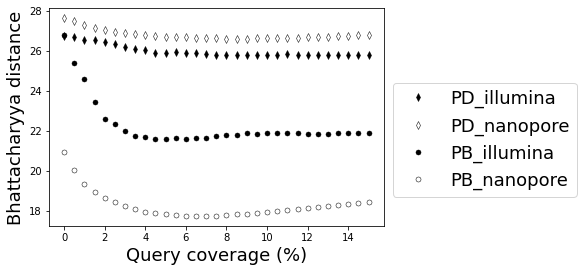

In [24]:
# Plot figure 5C
plt.plot(pmatch_X_Bdistances_IE1_illumina.pmatch, pmatch_X_Bdistances_IE1_illumina.b_distances, 
         linestyle='none', marker='d', markersize=5, markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5)
plt.plot(pmatch_X_Bdistances_IE1_nanopore.pmatch, pmatch_X_Bdistances_IE1_nanopore.b_distances, 
         linestyle='none', marker='d', markersize=5, markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5)
plt.plot(pmatch_X_Bdistances_MC1_nanopore.pmatch, pmatch_X_Bdistances_MC1_nanopore.b_distances, 
         linestyle='none', marker='o', markersize=5, markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5)
plt.plot(pmatch_X_Bdistances_MC1_illumina.pmatch, pmatch_X_Bdistances_MC1_illumina.b_distances, 
         linestyle='none', marker='o', markersize=5, markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5)

# figure legends
IE1_illumina_marker = mlines.Line2D([], [], linestyle='none', marker='d', markersize=5, 
                          markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5, label='PD_illumina')
IE1_nanopore_marker = mlines.Line2D([], [], linestyle='none', marker='d', markersize=5, 
                          markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5, label='PD_nanopore')
MC1_illumina_marker = mlines.Line2D([], [], linestyle='none', marker='o', markersize=5, 
                          markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5, label='PB_illumina')
MC1_nanopore_marker = mlines.Line2D([], [], linestyle='none', marker='o', markersize=5, 
                          markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5, label='PB_nanopore')

plt.legend(handles=[IE1_illumina_marker, IE1_nanopore_marker, MC1_illumina_marker, MC1_nanopore_marker], fontsize=18, bbox_to_anchor=(1, 0.7))

plt.xlabel("Query coverage (%)", fontsize=18)
plt.ylabel("Bhattacharyya distance", fontsize=18)
plt.savefig(os.path.join('/home/yiheng/MinION_data/figures', 'Figure5C.png'), bbox_inches='tight', dpi=1000)
plt.show()


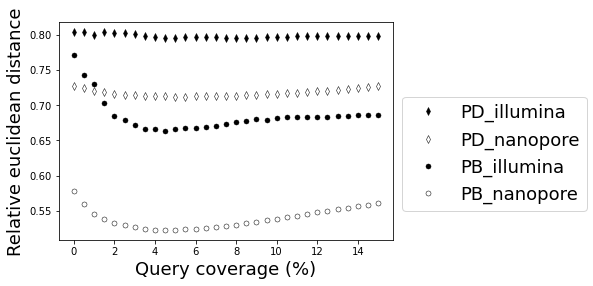

In [25]:
# Plot figure 5D
plt.plot(pmatch_X_L2distances_IE1_illumina.pmatch, pmatch_X_L2distances_IE1_illumina.L2_distances, 
         linestyle='none', marker='d', markersize=5, markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5)
plt.plot(pmatch_X_L2distances_IE1_nanopore.pmatch, pmatch_X_L2distances_IE1_nanopore.L2_distances, 
         linestyle='none', marker='d', markersize=5, markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5)
plt.plot(pmatch_X_L2distances_MC1_nanopore.pmatch, pmatch_X_L2distances_MC1_nanopore.L2_distances, 
         linestyle='none', marker='o', markersize=5, markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5)
plt.plot(pmatch_X_L2distances_MC1_illumina.pmatch, pmatch_X_L2distances_MC1_illumina.L2_distances, 
         linestyle='none', marker='o', markersize=5, markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5)

# figure legends
IE1_illumina_marker = mlines.Line2D([], [], linestyle='none', marker='d', markersize=5, 
                          markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5, label='PD_illumina')
IE1_nanopore_marker = mlines.Line2D([], [], linestyle='none', marker='d', markersize=5, 
                          markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5, label='PD_nanopore')
MC1_illumina_marker = mlines.Line2D([], [], linestyle='none', marker='o', markersize=5, 
                          markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5, label='PB_illumina')
MC1_nanopore_marker = mlines.Line2D([], [], linestyle='none', marker='o', markersize=5, 
                          markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5, label='PB_nanopore')

plt.legend(handles=[IE1_illumina_marker, IE1_nanopore_marker, MC1_illumina_marker, MC1_nanopore_marker], fontsize=18, bbox_to_anchor=(1, 0.7))

plt.xlabel("Query coverage (%)", fontsize=18)
plt.ylabel("Relative euclidean distance", fontsize=18)
plt.savefig(os.path.join('/home/yiheng/MinION_data/figures', 'Figure5D.png'), bbox_inches='tight', dpi=1000)
plt.show()


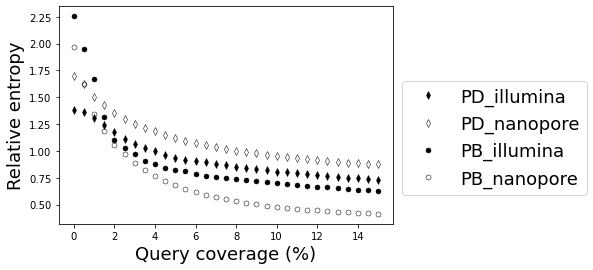

In [26]:
# Plot figure 5E
plt.plot(pmatch_X_KL_IE1_illumina.pmatch, pmatch_X_KL_IE1_illumina.KL_divergence, 
         linestyle='none', marker='d', markersize=5, markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5)
plt.plot(pmatch_X_KL_IE1_nanopore.pmatch, pmatch_X_KL_IE1_nanopore.KL_divergence, 
         linestyle='none', marker='d', markersize=5, markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5)
plt.plot(pmatch_X_KL_MC1_nanopore.pmatch, pmatch_X_KL_MC1_nanopore.KL_divergence, 
         linestyle='none', marker='o', markersize=5, markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5)
plt.plot(pmatch_X_KL_MC1_illumina.pmatch, pmatch_X_KL_MC1_illumina.KL_divergence, 
         linestyle='none', marker='o', markersize=5, markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5)

# figure legends
IE1_illumina_marker = mlines.Line2D([], [], linestyle='none', marker='d', markersize=5, 
                          markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5, label='PD_illumina')
IE1_nanopore_marker = mlines.Line2D([], [], linestyle='none', marker='d', markersize=5, 
                          markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5, label='PD_nanopore')
MC1_illumina_marker = mlines.Line2D([], [], linestyle='none', marker='o', markersize=5, 
                          markerfacecolor='black', markeredgecolor="k", markeredgewidth=0.5, label='PB_illumina')
MC1_nanopore_marker = mlines.Line2D([], [], linestyle='none', marker='o', markersize=5, 
                          markerfacecolor='none', markeredgecolor="k", markeredgewidth=0.5, label='PB_nanopore')

plt.legend(handles=[IE1_illumina_marker, IE1_nanopore_marker, MC1_illumina_marker, MC1_nanopore_marker], fontsize=18, bbox_to_anchor=(1, 0.7))

plt.xlabel("Query coverage (%)", fontsize=18)
plt.ylabel("Relative entropy", fontsize=18)
plt.savefig(os.path.join('/home/yiheng/MinION_data/figures', 'Figure5E.png'), bbox_inches='tight', dpi=1000)
plt.show()